# Integrantes:

* Andresa Bicudo
* Gabriel Yamashita
* Leonardo Malta

----

# Introdução 
A pandemia do corona vírus fez com que o futebol parasse, inclusive o campeonato inglês (Premiere League). Existem campeonatos que foram interrompidos, como o campeonato francês, mesmo sem ter finalizado todos os jogos e também há campeonatos que retonaram porém com desempenhos diferentes de cada equipe. Isso fez com que surgisse o seguinte questionamento: o que provavelmente ocorreria com o campeonato inglês se a pandemia não tivesse a interrompido?

----

# Objetivo:
Prever o restante do campeonato inglês com base no desempenho e estatísitcas das equipes até a 30ª rodada. 

----

# Imports:

In [1]:
# Importanto Bibliotecas para o Trabalho:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import scipy as scp
import sklearn

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

----

# Separação dos Dados:

In [2]:
# carregando os dados do Excell para o pandas
dados = pd.read_excel('masterdata.xlsx')
dados.head(5)

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,2007,18.84,21,19.28,25,10.52,25,0.00,19
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,2007,19.38,16,4.39,16,28.16,17,2.08,18
2,5939,Chelsea,Everton,1,1,59.3,40.7,7,6,20,11,615,471,425,305,23,22,10,28,10,2,6,2,2,1,13,7,0,0,2007,101.43,23,59.96,22,20.41,11,2.85,16
3,5940,Liverpool,Charlton,2,2,61.6,38.4,5,4,23,9,632,420,453,271,20,14,22,29,9,2,6,4,0,0,5,13,0,0,2007,52.44,27,23.94,28,24.68,31,2.59,36
4,5941,Man Utd,West Ham,0,1,65.3,34.7,7,2,30,8,825,506,619,333,28,26,18,47,14,3,0,1,0,2,13,12,0,0,2007,31.01,25,20.52,29,79.63,22,7.70,23


In [3]:
# separando os resultados em uma nova coluna e em números (0, 1 e 2)

def Determina_Resultado(df, home, away):
    if df[home] > df[away]: # se o time local ganhou do visitante
        return 0
    elif df[home] < df[away]: # se o time visitante ganhou do local
        return 2
    elif df[home] == df[away]: # se empatou
        return 1

# criando uma coluna com os números que representam os resultados
dados['Result'] = dados.apply(
    lambda dados: Determina_Resultado(dados, 'Score_home', 'Score_away'), axis=1)

# testando se deu certo
dados.head(5)

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,Result
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,2007,18.84,21,19.28,25,10.52,25,0.00,19,1
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,2007,19.38,16,4.39,16,28.16,17,2.08,18,1
2,5939,Chelsea,Everton,1,1,59.3,40.7,7,6,20,11,615,471,425,305,23,22,10,28,10,2,6,2,2,1,13,7,0,0,2007,101.43,23,59.96,22,20.41,11,2.85,16,1
3,5940,Liverpool,Charlton,2,2,61.6,38.4,5,4,23,9,632,420,453,271,20,14,22,29,9,2,6,4,0,0,5,13,0,0,2007,52.44,27,23.94,28,24.68,31,2.59,36,1
4,5941,Man Utd,West Ham,0,1,65.3,34.7,7,2,30,8,825,506,619,333,28,26,18,47,14,3,0,1,0,2,13,12,0,0,2007,31.01,25,20.52,29,79.63,22,7.70,23,2


----

# Desenvolvimento: 

In [4]:
# Definindo variáveis importantes: 
# removendo as colunas que não serão necessárias para calcular as probabilidades
stats = dados.drop(columns=[
    'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away',
    'year', 'Result'])

# definindo as colunas dos nomes dos times
games = dados.loc[: , ['Home_team', 'Away_team']]

# definindo as colunas do resultado (em 0, 1 e 2)
results = dados.loc[: , ['Result']]

stats.head(5)

,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,Tackles_home,Tackles_away,Clearances_home,Clearances_away,Corners_home,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away
0,54.0,46.0,6,4,15,11,553,464,356,287,22,13,33,19,5,10,5,3,2,0,18,7,0,0,18.84,21,19.28,25,10.52,25,0.00,19
1,47.1,52.9,2,2,11,7,457,493,318,343,24,15,23,20,7,6,0,2,2,1,10,11,0,0,19.38,16,4.39,16,28.16,17,2.08,18
2,59.3,40.7,7,6,20,11,615,471,425,305,23,22,10,28,10,2,6,2,2,1,13,7,0,0,101.43,23,59.96,22,20.41,11,2.85,16
3,61.6,38.4,5,4,23,9,632,420,453,271,20,14,22,29,9,2,6,4,0,0,5,13,0,0,52.44,27,23.94,28,24.68,31,2.59,36
4,65.3,34.7,7,2,30,8,825,506,619,333,28,26,18,47,14,3,0,1,0,2,13,12,0,0,31.01,25,20.52,29,79.63,22,7.70,23


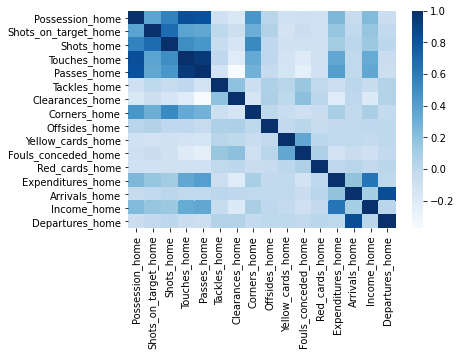

In [5]:
# Obtendo a correlação dos dados para times que jogam em seu estádio:
home_features = [i for i in list(stats) if '_home' in i]
corr = stats[home_features].corr()
sns.heatmap(corr, cmap="Blues")

### Fatores Relevantes:

A partir da análise do heatmap, é possível saber se duas variáveis estão medindo características similares. 
Por exemplo, a quantidade de passes ("touches_home") está muito interligada com a posse de bola. 
Para eliminar as variáveis que se relacionam, usa-se o **"Variance Inflation Factor"**, que é um fator que indentifica multicolinearidade de duas variáveis. 
**Valores maiores que 5** significam que há muita correlação. 

Mais informações em: https://www.statisticshowto.com/variance-inflation-factor/.

In [6]:
# Enumera elementos de uma lista para percorrer com o for
enumerate(list(stats))

In [7]:
# detectando a multicolinearidade entre características a partir do fator de inflação de variância
# armazenando esses valores numa lista
variance_inflation = []
for i, feature in enumerate(list(stats)):
    vif_tup = (feature, variance_inflation_factor(stats.values, i))
    variance_inflation.append(vif_tup)

    
# sabendo que os fatores maiores de 5 possuem alta multicolineariade
# selecionaremos apenas os que são menores (ou iguais, mas nesse caso não há diferença) que 5
# armazenando os relevantes em uma lista
relevant_features_vi = []
for i in range(len(variance_inflation)):
    if variance_inflation[i][1] <= 5:
        relevant_features_vi.append(variance_inflation[i][0])


print('Número de itens relevantes: {0}\n'.format(len(relevant_features_vi)))
print(relevant_features_vi)

Número de itens relevantes: 10

['Offsides_home', 'Offsides_away', 'Yellow_cards_home', 'Yellow_cards_away', 'Red_cards_home', 'Red_cards_away', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away']


#  Random Forest - Tentativa 1:
(A **Tentativa 1** é referente ao uso de todos os dados)

O Random Forest é um método de Regressão baseado em várias árvores de probabilidade. 
Cada uma delas faz as probabilidades separadamente usando ordens diferentes entre suas variáveis. 
Com isso, caso apresente algum erro, ele será minimizado.
Esse método é uma técnica de "bagging", já que as árvores funcionam paralelamente e não interferem umas nas outras.

In [8]:
# Teste sem retirada das variáveis (com alta multicolinearidade)

X = stats.values
y = results.values

# a função train_test_split() separa os grupos de teste (ou de treino)
# pelo protocolo, test_size deve ser .25 porque não usamos nenhum de train_size 
# 25% da base será teste, enquanto o treinamaneto será seu complemento (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

# aplicando o Random Forest
# n_estimators é o número de árvores no processo
classificador_RF = RandomForestClassifier(n_estimators=500, random_state=42)
classificador_RF.fit(X_train, y_train)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=500, random_state=42)

In [9]:
# Medindo a acurácia sem retirar as variáveis

RF_y_pred = classificador_RF.predict(X_test)

print('Acurácia do modelo Random Forest com todas as variáveis:',
      accuracy_score(y_test, RF_y_pred))

Acurácia do modelo Random Forest com todas as variáveis: 0.6145741878841089


# Random Forest - Tentativa 2:
(A **Tentativa 2** é referente ao uso das variáveis "relevantes")

In [10]:
# Predição com variáveis classificadas como relevantes (variance inflation menores que 5):

# X - dados relevantes
# Y - resultados
RF2_X = (stats.loc[:, relevant_features_vi]).values
RF2_y = results.values

In [11]:
# separando os grupos de teste (ou de treino)
RF2_X_train, RF2_X_test, RF2_y_train, RF2_y_test = train_test_split(
    RF2_X, RF2_y, test_size=.25, random_state=42)

# aplicando o Random Forest
classificador_RF2 = RandomForestClassifier(n_estimators=500, random_state=42)
classificador_RF2.fit(RF2_X_train, RF2_y_train)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(n_estimators=500, random_state=42)

In [12]:
# calculando a acurácia do método, utilizando apenas as variáveis relevantes

RF2_y_pred = classificador_RF2.predict(RF2_X_test)

print('Acurácia do modelo Random Forest somente com as variáveis determinadas pelo variance inflation :',
    accuracy_score(RF2_y_test, RF2_y_pred))

Acurácia do modelo Random Forest somente com as variáveis determinadas pelo variance inflation : 0.52414398595259


A conclusão que pode ser feita é a de que a "variance inflation" não é um bom parâmetro para determinar variáveis importantes. 

### Nova Seleção de Melhores Variáveis:

In [13]:
# encontrando a ordem de importância das variáveis, de acordo com o Random Forest

# calculando um novo Random Forest
forest = RandomForestClassifier(n_estimators=500,random_state=42)
forest.fit(X_train, y_train)

# organizando as variáveis
features = stats.columns
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
indices

# imprimindo a tabela
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 1) Shots_on_target_home           0.072378
 2) Shots_on_target_away           0.062956
 3) Clearances_away                0.061040
 4) Clearances_home                0.051419
 5) Expenditures_away              0.039544
 6) Passes_away                    0.038236
 7) Expenditures_home              0.037388
 8) Passes_home                    0.035814
 9) Touches_away                   0.035299
10) Income_away                    0.034413
11) Income_home                    0.033671
12) Touches_home                   0.033291
13) Shots_away                     0.032093
14) Shots_home                     0.030413
15) Possession_away                0.030288
16) Possession_home                0.029781
17) Tackles_home                   0.029175
18) Tackles_away                   0.028540
19) Arrivals_away                  0.028441
20) Departures_away                0.028000
21) Departures_home                0.026548
22) Arrivals_home                  0.026415
23) Fouls_conceded_away         

In [14]:
# Prevendo o melhor resultado por meio do Random Forest 

# A função nos ajuda a definir o número de variáveis que devemos usar para obter o melhor resultado 
def Resultado_RF(lista_variaveis, quantidade):
    relevant_features = []
    # seleciona os primeiros elementos da lista que queremos utilizar
    for i in range(len(lista_variaveis)): #features[indices]
        if i <= quantidade:
            relevant_features.append(lista_variaveis[i])
        else:
            pass
    
    # definindo novos X e Y
    RF3_X = (stats.loc[:, relevant_features]).values # X - os dados dos features relevantes
    RF3_y = results.values                           # Y - os resultados 
    
    # separando os fatores em teste e treinamento (0 - 1.0)
    RF3_X_train, RF3_X_test, RF3_y_train, RF3_y_test = train_test_split(
        RF3_X, RF3_y, test_size=.25, random_state=42)
    
    # aplicando o Random Forest
    classificador_RF = RandomForestClassifier(n_estimators=500, random_state=42)
    classificador_RF.fit(RF3_X_train, RF3_y_train)

    RF3_y_pred = classificador_RF.predict(RF3_X_test)
    
    # retornando o valor de acurácia do método com as variáveis utilizadas
    return accuracy_score(RF3_y_test, RF3_y_pred)

# Teste Função
Resultado_RF(features[indices], 1)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5645302897278315

In [15]:
# criando uma lista dos valores de acurácia conforme a quantidade de features mais relevantes utilizados
scores = []

for i in range(len(features[indices])):
    scores.append(Resultado_RF(features[indices], i))
    
scores

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vec

[0.5302897278314311,
 0.5645302897278315,
 0.5258999122036875,
 0.5618964003511853,
 0.5926251097453907,
 0.6189640035118525,
 0.6128182616330115,
 0.611062335381914,
 0.6136962247585601,
 0.6180860403863038,
 0.617208077260755,
 0.6136962247585601,
 0.6154521510096576,
 0.6119402985074627,
 0.6093064091308165,
 0.6101843722563652,
 0.617208077260755,
 0.6119402985074627,
 0.6224758560140474,
 0.617208077260755,
 0.62071992976295,
 0.6101843722563652,
 0.6198419666374012,
 0.6180860403863038,
 0.6198419666374012,
 0.6128182616330115,
 0.617208077260755,
 0.6154521510096576,
 0.6180860403863038,
 0.6163301141352063,
 0.6145741878841089,
 0.6215978928884986]

In [16]:
# listando os features realmente relevantes a partir da seleçÃo acima
RF_relevant_features = []

for i in range(len(features[indices])):
    if i < scores.index(max(scores)):
        RF_relevant_features.append(features[indices][i])

RF_relevant_features

['Shots_on_target_home',
 'Shots_on_target_away',
 'Clearances_away',
 'Clearances_home',
 'Expenditures_away',
 'Passes_away',
 'Expenditures_home',
 'Passes_home',
 'Touches_away',
 'Income_away',
 'Income_home',
 'Touches_home',
 'Shots_away',
 'Shots_home',
 'Possession_away',
 'Possession_home',
 'Tackles_home',
 'Tackles_away']

----

# Regressão Multinomianal - Tentativa 1:
(A **Tentativa 1** se refere ao uso de todos os dados)

A Regressão Multinomial é usada para relacionar uma variável nominal dependente (nesse caso, resultado de um jogo) e outras variáveis independentes (número de passes, time adversário, estádio).

In [17]:
# aplicando o método de Regressão Multinomial (RM)
# Y, endog é a variável endógena (de dentro) e o X, exog é a exógena (de fora)
# tirando os resultados (y) de uma organização em forma de tabela e tornando-o uma lista com o .flatten()

logit_model = sm.MNLogit(endog=y_train.flatten(), exog=X_train)
result = logit_model.fit()

# criando tabelas que explicitam os dados comparados e permitem a análise dos resultados
stats1 = result.summary()
stats2 = result.summary2()

print(stats1)

Optimization terminated successfully.
         Current function value: 0.774372
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 3417
Model:                        MNLogit   Df Residuals:                     3353
Method:                           MLE   Df Model:                           62
Date:                Wed, 10 Jun 2020   Pseudo R-squ.:                  0.2713
Time:                        14:40:38   Log-Likelihood:                -2646.0
converged:                       True   LL-Null:                       -3631.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1370      0.021      6.633      0.000       0.097       0.177
x2            -0.1454      0.

In [18]:
print(stats2)

                        Results: MNLogit
Model:              MNLogit          Pseudo R-squared: 0.271    
Dependent Variable: y                AIC:              5420.0570
Date:               2020-06-10 14:40 BIC:              5812.7942
No. Observations:   3417             Log-Likelihood:   -2646.0  
Df Model:           62               LL-Null:          -3631.2  
Df Residuals:       3353             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
--------------------------------------------------------------
 y = 0    Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------
 x1       0.1370    0.0207    6.6331  0.0000   0.0965   0.1775
 x2      -0.1454    0.0216   -6.7215  0.0000  -0.1878  -0.1030
 x3      -0.3681    0.0282  -13.0626  0.0000  -0.4233  -0.3129
 x4       0.1784    0.0314    5.6887  0.0000   0.1169   0.239

In [19]:
def Determina_Acuracia_Multinominal(predict, teste_y):
    lista_maiores = [max(i) for i in predict]
    lista_index = []
    for i in range(len(predict)):
        for p in range(3):
            if predict[i][p] == lista_maiores[i]:
                lista_index.append(p)

    flat_list_of_results = []
    for sublist in np.ndarray.tolist(teste_y):  #y_test
        for item in sublist:
            flat_list_of_results.append(item)

    comparativo_rm = pd.DataFrame({
        'Resultado': flat_list_of_results,
        'Modelo': lista_index
    })

    corretos = 0
    for i in range(len(comparativo_rm['Resultado'])):
        if comparativo_rm['Resultado'][i] == comparativo_rm['Modelo'][i]:
            corretos += 1

    accuracy = corretos / (len(comparativo_rm['Resultado']))

    print(
        'A acurácia desse modelo de Regressão Multinominal é: {}'
        .format(accuracy))

In [20]:
# Medindo a acurácia do método de Regressão Multinomial
RM_pred = result.predict(exog=X_test)
Determina_Acuracia_Multinominal(RM_pred, y_test)

A acurácia desse modelo de Regressão Multinominal é: 0.6312554872695347


#  Regressão Multinominal - Tentativa 2:
(A **Tentativa 2** se refere ao uso dos "Fatores Relevantes")

Por meio dos valores de "p", conclui-se que  serão eliminadas as variáveis que são maiores que 0.1 em pelo menos duas das listas do summary, ou seja: (x6, x7 x8, x11, x12, x15, x18, x20, x21, x22, x26, x27, x28, x29, x30, x31).

In [21]:
RM2_index_inrrelevant = [5, 6, 7, 10, 11, 14, 17, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31]
RM2_relevant_features = list(
    stats.drop(stats.columns[RM2_index_inrrelevant], axis=1).columns)

RM2_X = (stats.loc[:, RM2_relevant_features]).values
RM2_y = results.values

RM2_X_train, RM2_X_test, RM2_y_train, RM2_y_test = train_test_split(
    RM2_X, RM2_y, test_size=.25, random_state=42)

RM2_logit_model = sm.MNLogit(endog=RM2_y_train.flatten(), exog=RM2_X_train)
RM2_result = RM2_logit_model.fit()

RM2_stats1 = RM2_result.summary()
RM2_stats2 = RM2_result.summary2()

print(RM2_stats1)

Optimization terminated successfully.
         Current function value: 0.788035
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 3417
Model:                        MNLogit   Df Residuals:                     3387
Method:                           MLE   Df Model:                           28
Date:                Wed, 10 Jun 2020   Pseudo R-squ.:                  0.2584
Time:                        14:40:39   Log-Likelihood:                -2692.7
converged:                       True   LL-Null:                       -3631.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1402      0.019      7.563      0.000       0.104       0.177
x2            -0.1423      0.

In [22]:
print(RM2_stats2)

                        Results: MNLogit
Model:              MNLogit          Pseudo R-squared: 0.258    
Dependent Variable: y                AIC:              5445.4331
Date:               2020-06-10 14:40 BIC:              5629.5286
No. Observations:   3417             Log-Likelihood:   -2692.7  
Df Model:           28               LL-Null:          -3631.2  
Df Residuals:       3387             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
--------------------------------------------------------------
 y = 0    Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------
 x1       0.1402    0.0185    7.5633  0.0000   0.1039   0.1765
 x2      -0.1423    0.0198   -7.1865  0.0000  -0.1811  -0.1035
 x3      -0.3658    0.0278  -13.1723  0.0000  -0.4202  -0.3113
 x4       0.1722    0.0256    6.7265  0.0000   0.1220   0.222

In [23]:
# Predição 2 - Regressão Multinominal (Retirada de algumas variáveis)
RM2_pred = RM2_result.predict(exog=RM2_X_test)
Determina_Acuracia_Multinominal(RM2_pred, RM2_y_test)

A acurácia desse modelo de Regressão Multinominal é: 0.6268656716417911


#  Regressão Multinominal - Tentativa 3:
(dados do "Nova Seleção de Melhores Variáveis")

In [24]:
# Previsão com as variáveis relevantes do Random Forest 
RM3_X = (stats.loc[:, RF_relevant_features]).values
RM3_y = results.values

# separando teste e treino
RM3_X_train, RM3_X_test, RM3_y_train, RM3_y_test = train_test_split(
    RM3_X, RM3_y, test_size=.25, random_state=42)

RM3_logit_model = sm.MNLogit(endog=RM3_y_train.flatten(), exog=RM3_X_train)
RM3_result = RM3_logit_model.fit()

RM3_pred = RM3_result.predict(exog=RM3_X_test)
Determina_Acuracia_Multinominal(RM3_pred, RM3_y_test)

Optimization terminated successfully.
         Current function value: 0.793267
         Iterations 6
A acurácia desse modelo de Regressão Multinominal é: 0.62071992976295


----

#  Regressão Naive Bayes Multinomial - Tentativa 1:
(todos os dados)

In [25]:
NB_y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('Acurácia do modelo Naive Bayes Multinomial:', accuracy_score(y_test, NB_y_pred))

Acurácia do modelo Naive Bayes Multinomial: 0.4793678665496049


C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Regressão Naive Bayes Multinomial - Tentativa 2:
(dados do "Nova Seleção de Melhores Variáveis")

In [26]:
NB2_X = (stats.loc[:, RF_relevant_features]).values
NB2_y = results.values

NB2_X_train, NB2_X_test, NB2_y_train, NB2_y_test = train_test_split(
    NB2_X, NB2_y, test_size=.25, random_state=42)

classificador_NB_multinomial = MultinomialNB().fit(NB2_X_train, NB2_y_train)

NB2_y_pred = classificador_NB_multinomial.predict(NB2_X_test)
print('Acurácia do modelo Naive Bayes Multinomial:',
      accuracy_score(NB2_y_test, NB2_y_pred))

Acurácia do modelo Naive Bayes Multinomial: 0.47673397717295873


C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


----

# KNeighbors Classifier - Tentativa 1:
(todos os dados)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

236


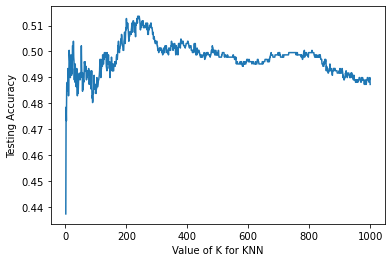

In [27]:
k_range = range(1,1001)
max_k = 0
max_k_value = 0
acuracia = []


for valor in k_range:
    classificador_KNeigh = KNeighborsClassifier(n_neighbors=valor)
    classificador_KNeigh.fit(X_train, y_train)
    KN_y_pred = classificador_KNeigh.predict(X_test)
    acuracia.append(accuracy_score(y_test, KN_y_pred))
    
for i in range(len(acuracia)):
    if max_k < acuracia[i]:
        max_k = acuracia[i]
        max_k_value = i
    
plt.plot(k_range, acuracia)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print(max_k_value)

In [28]:
classificador_KNeigh = KNeighborsClassifier(n_neighbors=max_k_value)
classificador_KNeigh.fit(X_train, y_train)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(n_neighbors=236)

In [29]:
KN_y_pred = classificador_KNeigh.predict(X_test)
print('Acurácia do modelo K Neighbors:', accuracy_score(y_test, KN_y_pred))

Acurácia do modelo K Neighbors: 0.5109745390693591


#  KNeighbors Classifier - Tentativa 2:
(dados do "Nova Seleção de Melhores Variáveis")

In [30]:
KN2_X = (stats.loc[:, RF_relevant_features]).values
KN2_y = results.values

In [31]:
KN2_X_train, KN2_X_test, KN2_y_train, KN2_y_test = train_test_split(KN2_X, KN2_y, test_size=.25, random_state=42)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

249


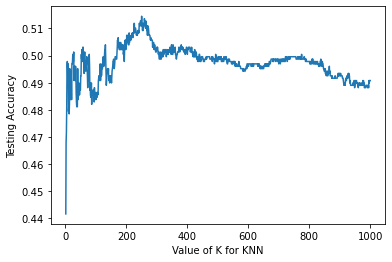

In [32]:
k_range = range(1,1001)
max_k2 = 0
max_k_value2 = 0
acuracia2 = []


for valor2 in k_range:
    classificador_KNeigh = KNeighborsClassifier(n_neighbors=valor2)
    classificador_KNeigh.fit(KN2_X_train, KN2_y_train)
    KN2_y_pred = classificador_KNeigh.predict(KN2_X_test)
    acuracia2.append(accuracy_score(KN2_y_test, KN2_y_pred))
    
for i in range(len(acuracia2)):
    if max_k2 < acuracia2[i]:
        max_k2 = acuracia2[i]
        max_k_value2 = i
    
plt.plot(k_range, acuracia2)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print(max_k_value2)

In [33]:
KN2_classificador = KNeighborsClassifier(n_neighbors=max_k_value2)
KN2_classificador.fit(KN2_X_train, KN2_y_train)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(n_neighbors=249)

In [34]:
KN2_y_pred = KN2_classificador.predict(KN2_X_test)
print('Acurácia do modelo K Neighbors:', accuracy_score(KN2_y_test, KN2_y_pred))

Acurácia do modelo K Neighbors: 0.5118525021949079


----

# Gradient Boosting Classificador - Tentativa 1:
(todos os dados)

In [35]:
classificador_Gradiente = GradientBoostingClassifier(random_state=0)
classificador_Gradiente.fit(X_train, y_train)
GB_y_pred = classificador_Gradiente.predict(X_test)
print('Acurácia do modelo Gradient Boosting:', accuracy_score(y_test, GB_y_pred))

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Acurácia do modelo Gradient Boosting: 0.6321334503950834


# Gradient Boosting Classificador - Tentativa 2:
(dados do "Nova Seleção de Melhores Variáveis")
Como esse modelo obteve uma acurácia grande, o objetivo é melhorá-lo, fazendo com que as melhors variáveis sejam utilizadas na análise. 

In [36]:
gradient_boosting = GradientBoostingClassifier(random_state=0)
gradient_boosting.fit(X_train, y_train)

features = stats.columns
importances = gradient_boosting.feature_importances_

indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


 1) Shots_on_target_home           0.231719
 2) Shots_on_target_away           0.192260
 3) Clearances_away                0.140204
 4) Clearances_home                0.102374
 5) Passes_away                    0.028154
 6) Expenditures_home              0.027801
 7) Passes_home                    0.026656
 8) Expenditures_away              0.023668
 9) Income_away                    0.021723
10) Touches_away                   0.018119
11) Income_home                    0.013949
12) Departures_away                0.013111
13) Shots_home                     0.010949
14) Tackles_home                   0.010765
15) Shots_away                     0.010706
16) Yellow_cards_home              0.010600
17) Arrivals_away                  0.010542
18) Fouls_conceded_away            0.010291
19) Possession_home                0.008860
20) Touches_home                   0.008620
21) Offsides_home                  0.007804
22) Red_cards_home                 0.007482
23) Possession_away             

In [37]:
def Resultado_GB(lista_variaveis, quantidade):
    relevant_features = []
    for i in range(len(lista_variaveis)): #features[indices]
        if i <= quantidade:
            relevant_features.append(lista_variaveis[i])
        else:
            pass
    
    GB_X = (stats.loc[:, relevant_features]).values
    GB_y = results.values

    GB_X_train, GB_X_test, GB_y_train, GB_y_test = train_test_split(
        GB_X, GB_y, test_size=.25, random_state=42)

    classificador_GB = GradientBoostingClassifier(random_state=0)
    classificador_GB.fit(GB_X_train, GB_y_train)

    GB_y_pred = classificador_GB.predict(GB_X_test)
    
    return accuracy_score(GB_y_test, GB_y_pred)

scores = []
for i in range(len(features[indices])):
    scores.append(Resultado_GB(features[indices], i))
    
scores

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[0.533801580333626,
 0.5671641791044776,
 0.5926251097453907,
 0.6233538191395961,
 0.6154521510096576,
 0.6180860403863038,
 0.6163301141352063,
 0.6154521510096576,
 0.6145741878841089,
 0.6251097453906936,
 0.6154521510096576,
 0.6242317822651449,
 0.6312554872695347,
 0.6277436347673397,
 0.6259877085162423,
 0.6224758560140474,
 0.6233538191395961,
 0.6330114135206322,
 0.6259877085162423,
 0.6277436347673397,
 0.617208077260755,
 0.6251097453906936,
 0.6224758560140474,
 0.6251097453906936,
 0.6312554872695347,
 0.6294995610184372,
 0.6294995610184372,
 0.6286215978928885,
 0.6268656716417911,
 0.6286215978928885,
 0.6338893766461808,
 0.6321334503950834]

----

# Fazendo Predições com o Modelo:

In [38]:
# Tabela Atual
table = pd.read_excel('Fixtures.xlsx',sheet_name='table')
table

,Team,Points
0,Liverpool,82
1,Man City,57
2,Leicester,53
3,Chelsea,48
4,Man Utd,45
5,Wolves,43
6,Sheffield Utd,43
7,Tottenham,41
8,Arsenal,40
9,Burley,39


In [39]:
# Confrontos Restantes:
fixtures = pd.read_excel('Fixtures.xlsx',sheet_name='next_fixtures')
fixtures.head(12)

,Home,Away,Round
0,Aston Villa,Sheffield Utd,28
1,Man City,Arsenal,28
2,Watford,Leicester,30
3,Man City,Burnley,30
4,Bournemouth,Crystal Palace,30
5,Norwich,Southampton,30
6,Brighton,Arsenal,30
7,Newcastle,Sheffield Utd,30
8,Aston Villa,Chelsea,30
9,West Ham,Wolves,30


In [40]:
def Prediction(df, home, away, result_model):
    matches = df.loc[(df['Home_team'] == home) & (df['Away_team'] == away), :]
    stats = matches.drop(columns=[
        'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away',
        'year', 'Result'])
    resumo = stats.mean().to_frame().T

    resultado = result_model.predict(resumo)
    return resultado

#teste
Prediction(dados, 'Norwich' , 'Southampton', classificador_Gradiente)

array([0], dtype=int64)

In [41]:
def Imput_Results(df, fixtures, result_model):
    Home = fixtures["Home"].tolist()
    Away = fixtures["Away"].tolist()
    predictions = []
    for i in range(len(Home)):
        try:
            print('----------------------------------')
            print(Home[i])
            print(Away[i])
            predictions.append(Prediction(df, Home[i], Away[i], result_model))
            print(Prediction(df, Home[i], Away[i], result_model))
            print('----------------------------------')
        except:
            predictions.append(3)
        
    return predictions

Imput_Results(dados, fixtures, classificador_Gradiente)

----------------------------------
Aston Villa
Sheffield Utd
[0]
----------------------------------
----------------------------------
Man City
Arsenal
[0]
----------------------------------
----------------------------------
Watford
Leicester
[2]
----------------------------------
----------------------------------
Man City
Burnley
[0]
----------------------------------
----------------------------------
Bournemouth
Crystal Palace
[2]
----------------------------------
----------------------------------
Norwich 
Southampton
----------------------------------
Brighton
Arsenal
[0]
----------------------------------
----------------------------------
Newcastle
Sheffield Utd
[0]
----------------------------------
----------------------------------
Aston Villa
Chelsea
[2]
----------------------------------
----------------------------------
West Ham
Wolves
[0]
----------------------------------
----------------------------------
Spurs
Man Utd
[0]
----------------------------------
--------

[array([0], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 3,
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 3,
 array([2], dtype=int64),
 array([0], dtype=int64),
 3,
 array([0], dtype=int64),
 3,
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 3,
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 3,
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dt